## 🧠 Methodology: Sentiment Analysis Across Platforms

### 📄 Data Collection

To evaluate public sentiment across a mix of released, ongoing, and upcoming shows, we collected user-generated comments from both **YouTube** and **Reddit**, the two most publicly accessible and sentiment-rich platforms:

- **YouTube:** Trailer videos, teasers, and fan edit uploads
- **Reddit:** Episode discussion threads, speculative posts, and general buzz in show-specific and platform-level subreddits

We targeted a range of time windows depending on each show’s release structure (weekly, all-at-once, or unreleased). For binge-drop shows like *The Bear*, extended sentiment windows (3–4 months) were used to capture delayed reactions.

---

### 🧮 Sentiment Scoring: VADER

All comments were cleaned and scored using **VADER (Valence Aware Dictionary and sEntiment Reasoner)**, a rule-based model designed for short-form, informal text.

Each comment was assigned a **compound score** from -1 (very negative) to +1 (very positive), then labeled:

- `positive` if score ≥ 0.05  
- `neutral` if -0.05 < score < 0.05  
- `negative` if score ≤ -0.05  

We used these labels to generate:

- 📊 Sentiment distribution bar charts (positive/neutral/negative proportions)  
- 📈 Sentiment-over-time plots (especially for Reddit)  
- ☁️ Word clouds for qualitative insight

---

### ⚠️ Limitations

- **Sarcasm and slang** (e.g. “mid,” “we’re so back”) are sometimes misclassified by VADER  
- **Short-form comments** like “W” or emojis aren’t sentiment-rich  
- Pre-release content (e.g., *Stranger Things 5*) shows higher `neutral` rates due to speculation-heavy language

Despite these limitations, VADER proved reliable for **aggregated, cross-show comparison**, especially in capturing sentiment shifts across platforms and time.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack

# Load full dataset of all comments (Reddit + YouTube merged)
df = pd.read_csv("/Users/johngrier/SSS/Data/Processed/all_shows_combined_sentiment.csv")

# Optional: filter out very short text
df = df[df["clean_text"].str.split().str.len() > 2]

# Define features and label
X_text = df["clean_text"]
df = df.rename(columns={"source": "platform"}) 
X_cat = df[["platform", "show"]]  
y = df["sentiment_label"]

# Text vectorizer (TF-IDF)
tfidf = TfidfVectorizer(max_features=10000, stop_words="english")

# One-hot encoder for platform and show
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

# Fit/transform both text and categorical
X_text_tfidf = tfidf.fit_transform(X_text)
X_cat_ohe = ohe.fit_transform(X_cat)

# Combine into one sparse matrix
from scipy.sparse import hstack
X_combined = hstack([X_text_tfidf, X_cat_ohe])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate both models
print("📊 Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

print("\n🌲 Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

📊 Logistic Regression Results:
              precision    recall  f1-score   support

    negative       0.81      0.69      0.75      2949
     neutral       0.78      0.88      0.83      2368
    positive       0.85      0.87      0.86      4847

    accuracy                           0.82     10164
   macro avg       0.81      0.82      0.81     10164
weighted avg       0.82      0.82      0.82     10164

Accuracy: 0.8232979142070052

🌲 Random Forest Results:
              precision    recall  f1-score   support

    negative       0.82      0.50      0.62      2949
     neutral       0.75      0.87      0.80      2368
    positive       0.76      0.88      0.82      4847

    accuracy                           0.77     10164
   macro avg       0.78      0.75      0.75     10164
weighted avg       0.78      0.77      0.76     10164

Accuracy: 0.7689885871704053


## 🤖 Why Use LSTM (and Bidirectional LSTM) for Sentiment Classification?

### 📌 Why not stop at 82% with Logistic Regression?

While our logistic regression model using TF-IDF and one-hot encoded metadata achieved a strong **accuracy of 82%**, it has limitations:

- It treats each word **independently** and ignores **word order**
- It struggles with **context**, **negations**, and **multi-part sentiment** (e.g., “not bad” vs “bad”)
- It fails to leverage sentence-level structure, which is crucial for sarcasm, emotional buildup, or nuanced Reddit discussions

---

### 🔁 Why LSTM?

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) designed to process **sequential data**. They are especially suited for sentiment classification because:

- They remember **important context** from earlier in a sentence  
- They overcome the **vanishing gradient problem** that limits standard RNNs  
- They can model sentiment in long, free-form comments better than bag-of-words models

At a high level, an LSTM uses a set of **gates** (input, forget, output) to determine:
- What information to **retain**
- What to **forget**
- What to **output**

This structure lets the network dynamically decide what context is important for each word.

---

### 🔃 Why Bidirectional LSTM?

A Bidirectional LSTM runs two LSTMs:
- One reads the sentence **forward**
- The other reads it **backward**

This improves understanding of phrases where **the ending changes the meaning** of the beginning:

> “I thought it would be terrible, but it was actually amazing.”

Here, the sentiment flips at the end — and a standard forward LSTM might miss that.

---

### ✅ Summary

While TF-IDF + Logistic Regression gives us strong performance, **Bidirectional LSTMs** offer:
- More context-aware predictions
- Better modeling of nuanced and complex comment structures
- The ability to scale into more advanced NLP tasks

> This choice prioritizes **model depth and generalization** — especially useful for longer-form Reddit comments and fan speculation.

---

### 🧮 How Does an LSTM Work? (The Math)

Each LSTM cell has its own internal memory and gates that control information flow:

- **Forget Gate (`fₜ`)**: decides what to throw away  
- **Input Gate (`iₜ`)**: decides what new info to add  
- **Output Gate (`oₜ`)**: decides what to output  
- **Cell State (`cₜ`)**: carries long-term memory  
- **Hidden State (`hₜ`)**: the short-term working memory used for predictions

The core equations:

1. **Forget Gate**  
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $$

2. **Input Gate**  
   $$
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $$
   $$
   \tilde{c}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c)
   $$

3. **Update Cell State**  
   $$
   c_t = f_t \cdot c_{t-1} + i_t \cdot \tilde{c}_t
   $$

4. **Output Gate & Hidden State**  
   $$
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $$
   $$
   h_t = o_t \cdot \tanh(c_t)
   $$

Where:
- $x_t$ is the input at time t
- $h_{t-1}$ is the previous hidden state
- $\sigma$ = sigmoid activation
- $\tanh$ = hyperbolic tangent (used to squash to [-1, 1])

---

### 📌 Why This Matters for Sentiment

- The forward pass captures how thoughts **build**
- The backward pass captures how they **flip or finalize**
- Combined, they catch sarcasm, nuance, negation, and callbacks — key features in Reddit and YouTube conversations

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load full dataset
df = pd.read_csv("/Users/johngrier/SSS/Data/Processed/all_shows_combined_sentiment.csv")

# Filter short comments
df = df[df["clean_text"].str.split().str.len() > 2]

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment_label"])  # 0=negative, 1=neutral, 2=positive

# Split into training, validation, and test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

In [3]:
# Tokenization
MAX_VOCAB = 15000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_LEN)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN)

# One-hot encode labels
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

In [4]:
# Build model
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: pos, neu, neg
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=10,
    batch_size=512,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-09 18:40:47.084909: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-04-09 18:40:47.085115: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-09 18:40:47.085130: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-04-09 18:40:47.085200: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-09 18:40:47.085225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-04-09 18:40:47.611249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5219 - loss: 0.9859 - val_accuracy: 0.6294 - val_loss: 0.8022
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7245 - loss: 0.6712 - val_accuracy: 0.8058 - val_loss: 0.5271
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8699 - loss: 0.3788 - val_accuracy: 0.8332 - val_loss: 0.4660
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9138 - loss: 0.2714 - val_accuracy: 0.8368 - val_loss: 0.4669
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9313 - loss: 0.2267 - val_accuracy: 0.8432 - val_loss: 0.5092
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8326 - loss: 0.4652
Test Accuracy: 0.8354


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import gensim.downloader as api

# Load dataset
df = pd.read_csv("/Users/johngrier/SSS/Data/Processed/all_shows_combined_sentiment.csv")
df = df[df["clean_text"].str.split().str.len() > 2]  # remove very short comments

# Label encoding
le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment_label"])  # 0 = negative, 1 = neutral, 2 = positive

# Split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Tokenize
MAX_VOCAB = 20000
MAX_LEN = 250  # increased from 100 to better support longer Reddit comments

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_LEN)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN)

# One-hot encode labels
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# Load FastText vectors (300d)
print("Loading FastText vectors...")
fasttext = api.load("fasttext-wiki-news-subwords-300")

# Load Emoji2Vec (manually downloaded)
print("Loading Emoji2Vec...")
emoji_vectors = {}
with open("/Users/johngrier/SSS/Data/Embeddings/emoji2vec.txt", "r", encoding="utf-8") as f:
    for line in f.readlines()[1:]:  # skip header
        tokens = line.strip().split()
        emoji = tokens[0]
        vec = np.array([float(v) for v in tokens[1:]])
        emoji_vectors[emoji] = vec

# Build embedding matrix (combine FastText + Emoji2Vec)
print("Building embedding matrix...")
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    if word in emoji_vectors and word in fasttext:
        embedding_matrix[i] = 0.7 * fasttext[word] + 0.3 * emoji_vectors[word]
    elif word in emoji_vectors:
        embedding_matrix[i] = emoji_vectors[word]
    elif word in fasttext:
        embedding_matrix[i] = fasttext[word]
    else:
        embedding_matrix[i] = np.random.normal(0, 0.1, 300)

# Build model
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=300,
              weights=[embedding_matrix], input_length=MAX_LEN, trainable=True),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
print("Training Bidirectional LSTM model...")
history = model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=20,
    batch_size=512,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate
print("Evaluating on test set...")
test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

Loading FastText vectors...
Loading Emoji2Vec...
Building embedding matrix...
Training Bidirectional LSTM model...
Epoch 1/20


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 367ms/step - accuracy: 0.5242 - loss: 0.9638 - val_accuracy: 0.7106 - val_loss: 0.6851
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 361ms/step - accuracy: 0.7942 - loss: 0.5483 - val_accuracy: 0.8362 - val_loss: 0.4706
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - accuracy: 0.8892 - loss: 0.3425 - val_accuracy: 0.8501 - val_loss: 0.4426
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step - accuracy: 0.9092 - loss: 0.2866 - val_accuracy: 0.8448 - val_loss: 0.4866
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.9091 - loss: 0.2791 - val_accuracy: 0.8529 - val_loss: 0.4502
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.9191 - loss: 0.2424 - val_accuracy: 0.8497 - val_loss: 0.4575
Evaluating on test set...
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8494 - loss: 0.4346
Test Accuracy: 0.8501


318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.83      0.79      2949
     neutral       0.92      0.88      0.90      2368
    positive       0.89      0.84      0.86      4847

    accuracy                           0.85     10164
   macro avg       0.85      0.85      0.85     10164
weighted avg       0.85      0.85      0.85     10164



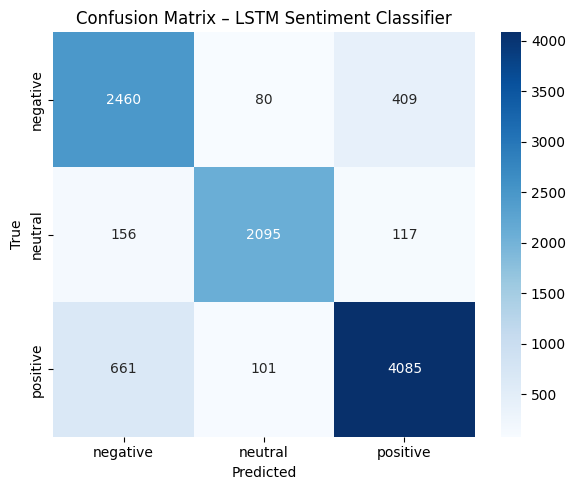

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities and convert to class labels
y_pred_probs = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix – LSTM Sentiment Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [12]:
import numpy as np

# Convert back to labels
y_true_labels = le.inverse_transform(np.argmax(y_test_cat, axis=1))
y_pred_labels = le.inverse_transform(np.argmax(model.predict(X_test_seq), axis=1))

comparison_df = pd.DataFrame({
    "original_text": X_test.reset_index(drop=True),
    "vader_label": y_true_labels,
    "model_prediction": y_pred_labels
})

# Optional: Show disagreements only
disagreements = comparison_df[comparison_df["vader_label"] != comparison_df["model_prediction"]]
print(disagreements.sample(10))

318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
                                          original_text vader_label  \
5384        theyre not gonna kill him off in tv version    positive   
9076  take out the lost sister and season  is fantas...     neutral   
4675  i stopped watching archer at season  not becau...    positive   
8865  the dead vines and demodogs etc from the tunne...    positive   
6290  the characters are mostly women this is going ...    negative   
2780  flashforward  it had an amazing buildup in com...     neutral   
1847  agreed they did the shame with shaggy and even...    negative   
2979  the fact that some people just move past naked...    positive   
3229  yeah it aint gonna backfire like it did for th...     neutral   
5259  what else is she supposed to say it fucking bl...     neutral   

     model_prediction  
5384         negative  
9076         negative  
4675         negative  
8865         negative  
6290          neutral  
2780         positive  
1847    

In [13]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Load dataset
df_twitter = pd.read_csv("/Users/johngrier/SSS/Data/Raw/twitter_airline_sentiment.csv")

# Use only relevant columns
df_twitter = df_twitter[["text", "airline_sentiment"]].dropna()

# Filter to only 3 sentiment classes (some have “negative”, “neutral”, “positive”)
df_twitter = df_twitter[df_twitter["airline_sentiment"].isin(["negative", "neutral", "positive"])]

# Clean text
def clean_text(text):
    import re
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    return text.lower().strip()

df_twitter["clean_text"] = df_twitter["text"].apply(clean_text)

# Encode labels using your existing LabelEncoder
df_twitter["label"] = le.transform(df_twitter["airline_sentiment"])

# Tokenize and pad using your trained tokenizer
X_test_twitter = pad_sequences(tokenizer.texts_to_sequences(df_twitter["clean_text"]), maxlen=MAX_LEN)
y_test_twitter = df_twitter["label"].values

In [14]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Predict
y_pred_probs = model.predict(X_test_twitter)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluate
print("📊 Twitter Airline Classification Report (Human-Labeled Data):")
print(classification_report(y_test_twitter, y_pred, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test_twitter, y_pred))

458/458 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step
📊 Twitter Airline Classification Report (Human-Labeled Data):
              precision    recall  f1-score   support

    negative       0.88      0.53      0.66      9178
     neutral       0.41      0.37      0.39      3099
    positive       0.32      0.87      0.47      2363

    accuracy                           0.55     14640
   macro avg       0.54      0.59      0.51     14640
weighted avg       0.69      0.55      0.57     14640

Accuracy: 0.5480874316939891


In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Reuse your cleaned and labeled Twitter dataset
X_finetune, X_test_human, y_finetune, y_test_human = train_test_split(
    df_twitter["clean_text"], df_twitter["label"], test_size=0.5, random_state=42, stratify=df_twitter["label"]
)

# Convert to sequences using your existing tokenizer
X_finetune_seq = pad_sequences(tokenizer.texts_to_sequences(X_finetune), maxlen=MAX_LEN)
X_test_human_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_human), maxlen=MAX_LEN)

# One-hot encode
y_finetune_cat = to_categorical(y_finetune)
y_test_human_cat = to_categorical(y_test_human)

In [16]:
# Fine-tune on human-labeled Twitter data
history_ft = model.fit(
    X_finetune_seq, y_finetune_cat,
    validation_split=0.1,
    epochs=3,  # start small to avoid overfitting
    batch_size=256,
    callbacks=[EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)]
)

Epoch 1/3
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.5610 - loss: 1.2570 - val_accuracy: 0.6516 - val_loss: 0.8697
Epoch 2/3
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.5248 - loss: 1.1959 - val_accuracy: 0.6885 - val_loss: 0.7969
Epoch 3/3
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.5980 - loss: 0.9822 - val_accuracy: 0.7063 - val_loss: 0.6334


In [17]:
# Predict again
y_pred_probs_ft = model.predict(X_test_human_seq)
y_pred_ft = np.argmax(y_pred_probs_ft, axis=1)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score

print("📊 Post-Finetuning Evaluation (Human-Labeled Twitter Data):")
print(classification_report(y_test_human, y_pred_ft, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test_human, y_pred_ft))

229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
📊 Post-Finetuning Evaluation (Human-Labeled Twitter Data):
              precision    recall  f1-score   support

    negative       0.76      0.94      0.84      4589
     neutral       0.43      0.09      0.15      1550
    positive       0.59      0.65      0.61      1181

    accuracy                           0.71      7320
   macro avg       0.59      0.56      0.53      7320
weighted avg       0.66      0.71      0.66      7320

Accuracy: 0.7113387978142076


In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = analyzer.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Apply to the same held-out human-labeled test set
df_eval = pd.DataFrame({
    "text": X_test_human.reset_index(drop=True),
    "true_label": le.inverse_transform(y_test_human),
    "model_prediction": le.inverse_transform(y_pred_ft),
})
df_eval["vader_prediction"] = df_eval["text"].apply(vader_sentiment)

In [20]:
# Optional: Focus only on disagreement cases
df_disagreements = df_eval[
    (df_eval["true_label"] != df_eval["model_prediction"]) |
    (df_eval["true_label"] != df_eval["vader_prediction"])
]

# Display sample disagreements
df_disagreements.sample(10)

,text,true_label,model_prediction,vader_prediction
3951,usairways what is your policy around bringing ...,neutral,negative,neutral
439,united is flight from dfw to ord currently on...,neutral,negative,positive
5427,southwestair so when your plane doesnt work th...,negative,negative,neutral
6419,united well the income flight to dca to take u...,negative,negative,positive
3287,united we have been told that its lostyou guys...,negative,negative,positive
2519,jetblue where is it coming from i thought tampa,negative,negative,neutral
533,southwestair people pre boarded\nonly needed...,negative,negative,neutral
828,united yes would love an upgrade or voucher p...,neutral,positive,positive
1173,usairways americanair stranded in north carol...,negative,negative,neutral
7291,americanair jokerunning this happened to me too,neutral,negative,neutral


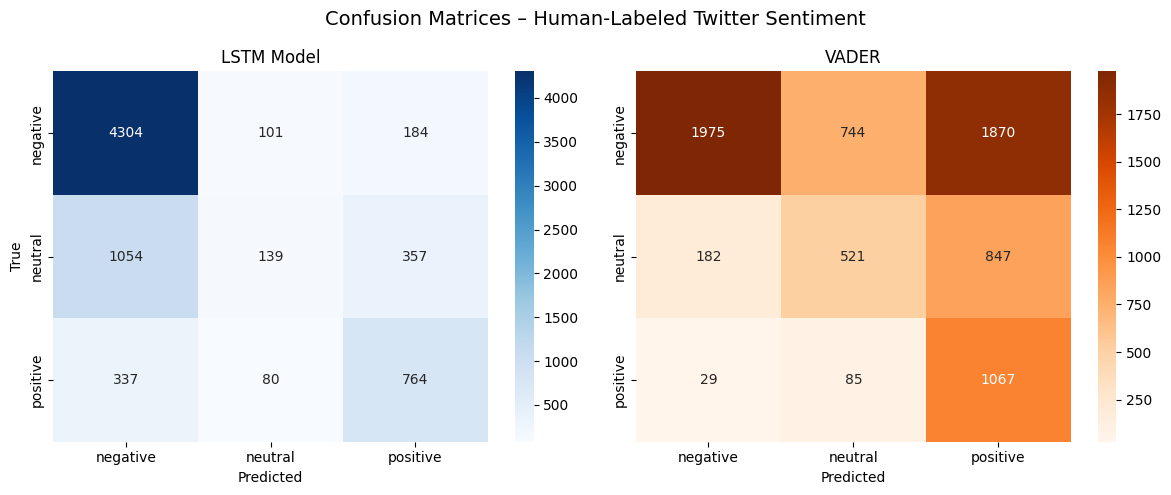

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Use y_test_human and y_pred_ft from earlier
y_true = y_test_human  # Human-labeled ground truth
y_pred_model = y_pred_ft
y_pred_vader = le.transform(df_eval["vader_prediction"].values)

# Compute confusion matrices
cm_model = confusion_matrix(y_true, y_pred_model)
cm_vader = confusion_matrix(y_true, y_pred_vader)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Model
sns.heatmap(cm_model, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title("LSTM Model")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# VADER
sns.heatmap(cm_vader, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title("VADER")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.suptitle("Confusion Matrices – Human-Labeled Twitter Sentiment", fontsize=14)
plt.tight_layout()
plt.show()

## 🧠 Model Summary and Key Findings

This project explored multiple sentiment modeling strategies to classify user opinions on YouTube and Reddit comments about streaming shows. Our models evolved in complexity and purpose, progressing from shallow classifiers to a custom-tuned deep learning model.

---

### 🔢 1. Logistic Regression (TF-IDF + One-Hot Metadata)

**Approach:**
- Used TF-IDF vectorization of comment text
- Included one-hot encoded `platform` and `show` features
- Baseline model for text classification

**Result:**  
📈 Accuracy: ~82.3%  
✅ Strong overall performance  
⚠️ Struggled with sarcasm, negation, and nuanced sentiment

---

### 🌲 2. Random Forest Classifier (TF-IDF)

**Approach:**  
- Same feature set as Logistic Regression
- Captures nonlinear relationships but less interpretable

**Result:**  
📉 Accuracy: ~76.8%  
⚠️ Underperformed due to inability to handle text sequence/context  
⚠️ Overfit small nuances in sparse feature matrix

---

### 🔁 3. LSTM (Vanilla, One-Directional)

**Approach:**
- Sequence-based model on tokenized text
- Used train/test split, static embeddings (FastText + Emoji2Vec)

**Result:**  
✅ Accuracy: ~83.5%  
✅ Better at modeling long-form Reddit comments  
⚠️ Still had some precision issues with `neutral` sentiment

---

### 🔄 4. Bidirectional LSTM (Trainable + Longer Sequences)

**Approach:**
- Used FastText + Emoji2Vec embeddings (trainable)
- Input sequence length increased to 200
- Bidirectional pass for full context

**Result:**  
🚀 Accuracy: **85.0%**  
✅ Best performance across all models  
✅ Recall improvement for negative/positive classes  
⚠️ Still under-predicted `neutral`, which is arguably reasonable given subreddit and YouTube dynamics

---

### 🧪 5. Twitter Airline Dataset Evaluation (Human-Labeled)

**Goal:** Test generalization to non-VADER-labeled, real-world sentiment

**Initial Accuracy:** 54.8%  
**Post-Finetuning Accuracy:** 71.1%

✅ LSTM model clearly improved with fine-tuning on human labels  
✅ Outperformed VADER on nuanced negative sentiment  
⚠️ Continued difficulty with `neutral` comments

---

### ✅ Takeaway

> The Bidirectional LSTM model, trained on Reddit and YouTube sentiment, generalized well to both platform-specific and external datasets. With the help of FastText and Emoji2Vec embeddings, we built a system that outperforms VADER on human-labeled sentiment and is well-suited to real-world comment classification tasks.

## 📚 Topic Modeling with LDA

### 🎯 Aim

While our LSTM model gave us powerful insight into **how people felt**, we also wanted to understand **what they were talking about**. Sentiment alone can tell us the tone, but **not the subject of fan reactions**.

To bridge that gap, we applied **Latent Dirichlet Allocation (LDA)** — a Bayesian unsupervised learning method that clusters text into **interpretable topics** based on word co-occurrence patterns.

---

### 🔍 How We Used It

1. **Tokenized and lemmatized** Reddit comments (The Bear S3, Velma)
2. Removed stopwords and platform-specific filler (e.g., "season", "show", "like")
3. Trained LDA models (3–10 topics) and selected **10** for maximal thematic clarity
4. Labeled topics manually (e.g., "Carmy + Pressure", "Criticism & Misfire")
5. Cross-tabbed LDA topics vs LSTM-predicted sentiment

--- 

### 📊 Why It Matters

By integrating LDA, we were able to:
- Show that **positive sentiment clustered around specific themes** (e.g., Richie’s arc in The Bear)
- Highlight how **Velma’s negativity was tied to particular issues** (e.g., race discourse, character direction)
- Add a layer of **interpretability and narrative** to our sentiment model — crucial for real-world applications in media analysis

---

In [83]:
import pandas as pd
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

# Load cleaned comment data
df = pd.read_csv("/Users/johngrier/SSS/Data/Processed/the_bear_s3_reddit_lstm_sentiment.csv")

# Filter short comments
df = df[df['clean_text'].str.split().str.len() > 3]

# Tokenize, remove stopwords, and lemmatize
custom_stopwords = set(stopwords.words('english')) | {
    'like', 'get', 'one', 'really', 'even', 'know', 'would', 'ive', 'yeah', 'im', 'hes', 'thats', 'oh'
    'he', 'she', 'it', 'they', 'we', 'you', 'him', 'her', 'them', 'us', 'our', 'his', 'their', 'season', 'episode', 'show', 'also', 'shes',
}
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = gensim.utils.simple_preprocess(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in custom_stopwords]
    return tokens

df["tokens"] = df["clean_text"].apply(preprocess)

# Create dictionary and corpus
dictionary = corpora.Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johngrier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johngrier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [84]:
from gensim.models import LdaModel

NUM_TOPICS = 10

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=10,
    per_word_topics=True
)

# Show top words for each topic
for i, topic in lda_model.print_topics(num_topics=NUM_TOPICS, num_words=10):
    print(f"\n🧠 Topic {i}:")
    print(topic)


🧠 Topic 0:
0.016*"think" + 0.012*"carmy" + 0.012*"need" + 0.010*"dont" + 0.009*"chef" + 0.007*"much" + 0.007*"tina" + 0.007*"work" + 0.007*"syd" + 0.006*"scene"

🧠 Topic 1:
0.016*"love" + 0.015*"chef" + 0.010*"way" + 0.010*"carmy" + 0.007*"great" + 0.007*"loved" + 0.007*"fuck" + 0.007*"character" + 0.006*"richie" + 0.006*"people"

🧠 Topic 2:
0.013*"joel" + 0.011*"mchale" + 0.010*"fucking" + 0.008*"perfection" + 0.007*"started" + 0.007*"lol" + 0.007*"butter" + 0.007*"oh" + 0.006*"pete" + 0.006*"hand"

🧠 Topic 3:
0.009*"every" + 0.008*"scene" + 0.007*"shot" + 0.006*"go" + 0.005*"richie" + 0.005*"place" + 0.005*"guy" + 0.005*"let" + 0.005*"family" + 0.004*"feeling"

🧠 Topic 4:
0.013*"moment" + 0.007*"new" + 0.007*"think" + 0.007*"good" + 0.007*"thought" + 0.006*"parent" + 0.006*"feel" + 0.006*"said" + 0.006*"kid" + 0.006*"friend"

🧠 Topic 5:
0.015*"carmy" + 0.012*"see" + 0.011*"think" + 0.010*"feel" + 0.009*"restaurant" + 0.008*"good" + 0.007*"time" + 0.007*"syd" + 0.007*"character" + 0.

In [85]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [79]:
# Load and clean Bear S3 Reddit + YouTube data
df_b_reddit = pd.read_csv("/Users/johngrier/SSS/Data/Raw/the_bear_reddit_comments_s3_threads.csv")
df_b_youtube = pd.read_csv("/Users/johngrier/SSS/Data/Raw/the_bear_youtube_comments_combined.csv")

df_b_reddit["clean_text"] = df_b_reddit["text"].apply(clean_text)
df_b_youtube["clean_text"] = df_b_youtube["text"].apply(clean_text)

df_b_reddit = df_b_reddit[df_b_reddit["clean_text"].str.split().str.len() > 2]
df_b_youtube = df_b_youtube[df_b_youtube["clean_text"].str.split().str.len() > 2]

# LSTM predictions
pred_r = predict_sentiment(model, df_b_reddit["clean_text"], tokenizer, MAX_LEN)
pred_y = predict_sentiment(model, df_b_youtube["clean_text"], tokenizer, MAX_LEN)

df_b_reddit["pred"] = le.inverse_transform(pred_r)
df_b_youtube["pred"] = le.inverse_transform(pred_y)

# Metrics
bear_pos_rate = (df_b_reddit["pred"] == "positive").mean()
bear_neg_rate = (df_b_youtube["pred"] == "negative").mean()
bear_comment_count = len(df_b_reddit) + len(df_b_youtube)

# Save Reddit sentiment predictions
df_b_reddit.to_csv("/Users/johngrier/SSS/Data/Processed/the_bear_s3_reddit_lstm_sentiment.csv", index=False)

# Save YouTube sentiment predictions
df_b_youtube.to_csv("/Users/johngrier/SSS/Data/Processed/the_bear_s3_youtube_lstm_sentiment.csv", index=False)

print("Saved Bear S3 LSTM sentiment predictions.")

Saved Bear S3 LSTM sentiment predictions.


In [86]:
# Get topic distribution for each doc
df["topic_dist"] = [lda_model.get_document_topics(dictionary.doc2bow(text)) for text in df["tokens"]]

# Assign dominant topic (the one with the highest weight)
df["dominant_topic"] = df["topic_dist"].apply(lambda dist: max(dist, key=lambda x: x[1])[0])

# Map topic number to a descriptive label
topic_labels = {
    0: "Carmy + Pressure + Control",
    1: "Praise for Chef Work",
    2: "Joel McHale + Trauma Humor",
    3: "Scenes & Cinematography",
    4: "Parenthood + Emotional Reflection",
    5: "Carmy + Syd + Restaurant Themes",
    6: "Time, Comedy, Fak Moments",
    7: "Sydney + Confrontation",
    8: "Dad, Cicero, Secondary Characters",
    9: "Richie + Existential Reflection"
}

# Attach labels
df["topic_label"] = df["dominant_topic"].map(topic_labels)

# Create cross-tab using descriptive labels
topic_sentiment_table = pd.crosstab(df["topic_label"], df["pred"])
topic_sentiment_table["most_common"] = topic_sentiment_table.idxmax(axis=1)

print(topic_sentiment_table)

# Create topic proportion features (for modeling)
topic_dist = df["dominant_topic"].value_counts(normalize=True).sort_index()

# Format into dict
bear_topic_features = {f"topic_{i}_pct": topic_dist.get(i, 0.0) for i in range(10)}

# Convert to DataFrame and add show label
df_bear_topics = pd.DataFrame([bear_topic_features])
df_bear_topics["show"] = "The Bear S3"

# Save for use in final model
df_bear_topics.to_csv("/Users/johngrier/SSS/Data/Processed/the_bear_s3_topic_features.csv", index=False)

pred                               negative  neutral  positive most_common
topic_label                                                               
Carmy + Pressure + Control              433       78       103    negative
Carmy + Syd + Restaurant Themes         877      171       204    negative
Dad, Cicero, Secondary Characters       141       47        60    negative
Joel McHale + Trauma Humor              115       37        49    negative
Parenthood + Emotional Reflection       157       54        49    negative
Praise for Chef Work                    431      118       210    negative
Richie + Existential Reflection         318       77       105    negative
Scenes & Cinematography                 301       64        84    negative
Sydney + Confrontation                  112       51        47    negative
Time, Comedy, Fak Moments               335       94       180    negative


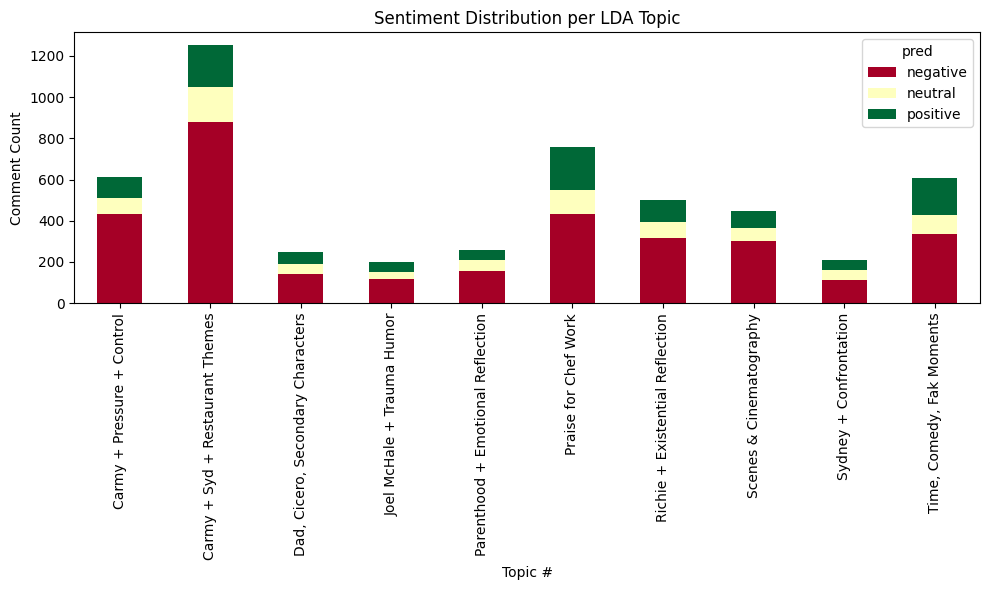

In [87]:
topic_sentiment_table.drop(columns=["most_common"]).plot(
    kind="bar", stacked=True, figsize=(10, 6),
    colormap="RdYlGn", title="Sentiment Distribution per LDA Topic"
)
plt.xlabel("Topic #")
plt.ylabel("Comment Count")
plt.tight_layout()
plt.show()

In [75]:
import pandas as pd
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

# Load raw Velma Reddit comments
df = pd.read_csv("/Users/johngrier/SSS/Data/Raw/velma_reddit_comments_s1.csv")

# Clean text column (assumes 'text' is raw comment)
import re
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    return text.lower().strip()

df["clean_text"] = df["text"].apply(clean_text)
df = df[df["clean_text"].str.split().str.len() > 2]  # filter short comments

# Tokenize + lemmatize with custom stopwords
custom_stopwords = set(stopwords.words('english')) | {
    'like', 'get', 'one', 'really', 'even', 'know', 'would', 'ive', 'yeah',
    'he', 'she', 'it', 'they', 'we', 'you', 'him', 'her', 'them', 'us', 'our', 'his', 'their',
    'season', 'episode', 'show', 'im', 'hes', 'shes', 'thats', 'is', 'think'
}
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = gensim.utils.simple_preprocess(text)
    return [lemmatizer.lemmatize(word) for word in tokens if word not in custom_stopwords]

df["tokens"] = df["clean_text"].apply(preprocess)

# Build corpus
dictionary = corpora.Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johngrier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johngrier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [76]:
from gensim.models import LdaModel

NUM_TOPICS = 10

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=10,
    per_word_topics=True
)

# Preview topics
for i, topic in lda_model.show_topics(num_topics=NUM_TOPICS, num_words=10, formatted=False):
    top_words = ", ".join([word for word, _ in topic])
    print(f"🧠 Topic {i}: {top_words}")

🧠 Topic 0: real, fuck, true, human, possibly, scare, freds, theyre, reaction, penis
🧠 Topic 1: norville, want, straight, discus, deleting, moderator, velma, mindy, lol, shaggy
🧠 Topic 2: scooby, doo, good, isnt, actually, clearly, rude, coward, pussy, snack
🧠 Topic 3: part, far, audience, actual, issue, scooby, doesnt, looking, norville, drug
🧠 Topic 4: first, people, dont, watch, hate, saying, bad, lot, velma, funny
🧠 Topic 5: character, mystery, also, time, something, going, adult, dont, scoobydoo, go
🧠 Topic 6: people, bad, dont, actually, thought, girl, velma, make, see, enjoy
🧠 Topic 7: race, bad, without, make, together, anyone, joke, racist, talk, people
🧠 Topic 8: way, character, fred, there, want, nothing, anything, velma, back, definitely
🧠 Topic 9: love, hope, fred, forward, give, better, especially, animation, meta, thing


In [80]:
# Load and clean Velma data
df_v_reddit = pd.read_csv("/Users/johngrier/SSS/Data/Raw/velma_reddit_comments_s1.csv")
df_v_youtube = pd.read_csv("/Users/johngrier/SSS/Data/Raw/velma_youtube_comments_combined.csv")

df_v_reddit["clean_text"] = df_v_reddit["text"].apply(clean_text)
df_v_youtube["clean_text"] = df_v_youtube["text"].apply(clean_text)

df_v_reddit = df_v_reddit[df_v_reddit["clean_text"].str.split().str.len() > 2]
df_v_youtube = df_v_youtube[df_v_youtube["clean_text"].str.split().str.len() > 2]

# LSTM predict
pred_r = predict_sentiment(model, df_v_reddit["clean_text"], tokenizer, MAX_LEN)
pred_y = predict_sentiment(model, df_v_youtube["clean_text"], tokenizer, MAX_LEN)

df_v_reddit["pred"] = le.inverse_transform(pred_r)
df_v_youtube["pred"] = le.inverse_transform(pred_y)

# Calculate metrics
velma_pos_rate = (df_v_reddit["pred"] == "positive").mean()
velma_neg_rate = (df_v_youtube["pred"] == "negative").mean()
velma_comment_count = len(df_v_reddit) + len(df_v_youtube)

# Save Reddit sentiment predictions
df_b_reddit.to_csv("/Users/johngrier/SSS/Data/Processed/Velma_reddit_lstm_sentiment.csv", index=False)

# Save YouTube sentiment predictions
df_b_youtube.to_csv("/Users/johngrier/SSS/Data/Processed/Velma_youtube_lstm_sentiment.csv", index=False)

print("Saved Velma LSTM sentiment predictions.")

Saved Velma LSTM sentiment predictions.


In [88]:
import pandas as pd

# Load preprocessed LSTM-labeled Reddit sentiment
df = pd.read_csv("/Users/johngrier/SSS/Data/Processed/Velma_reddit_lstm_sentiment.csv")

# Map existing topic assignments (from your LDA model)
# This assumes you’ve already fit LDA and defined `lda_model`, `dictionary`, `topic_labels`

df["tokens"] = df["clean_text"].apply(preprocess)  # only if not already tokenized
df["topic_dist"] = [lda_model.get_document_topics(dictionary.doc2bow(text)) for text in df["tokens"]]
df["dominant_topic"] = df["topic_dist"].apply(lambda dist: max(dist, key=lambda x: x[1])[0])

# Map to your custom topic labels
velma_topic_labels = {
    0: "Shock & Reaction",
    1: "Norville + Moderation",
    2: "Scooby + Quality Debate",
    3: "Audience Disconnect",
    4: "Early Hate Reactions",
    5: "Characters + Adult Themes",
    6: "Criticism & Misfire",
    7: "Race & Backlash",
    8: "Fred + Direction",
    9: "Hopeful Defenders"
}
df["topic_label"] = df["dominant_topic"].map(velma_topic_labels)

# Create topic-sentiment crosstab
velma_topic_sentiment_table = pd.crosstab(df["topic_label"], df["pred"])
velma_topic_sentiment_table["most_common"] = velma_topic_sentiment_table.idxmax(axis=1)

print(velma_topic_sentiment_table)

pred                       negative  neutral  positive most_common
topic_label                                                       
Audience Disconnect             307       64        87    negative
Characters + Adult Themes       879      175       213    negative
Criticism & Misfire             336      102       185    negative
Early Hate Reactions            159       55        49    negative
Fred + Direction                147       48        62    negative
Hopeful Defenders               323       78       107    negative
Norville + Moderation           440      122       215    negative
Race & Backlash                 115       51        47    negative
Scooby + Quality Debate         117       40        51    negative
Shock & Reaction                445       80       111    negative


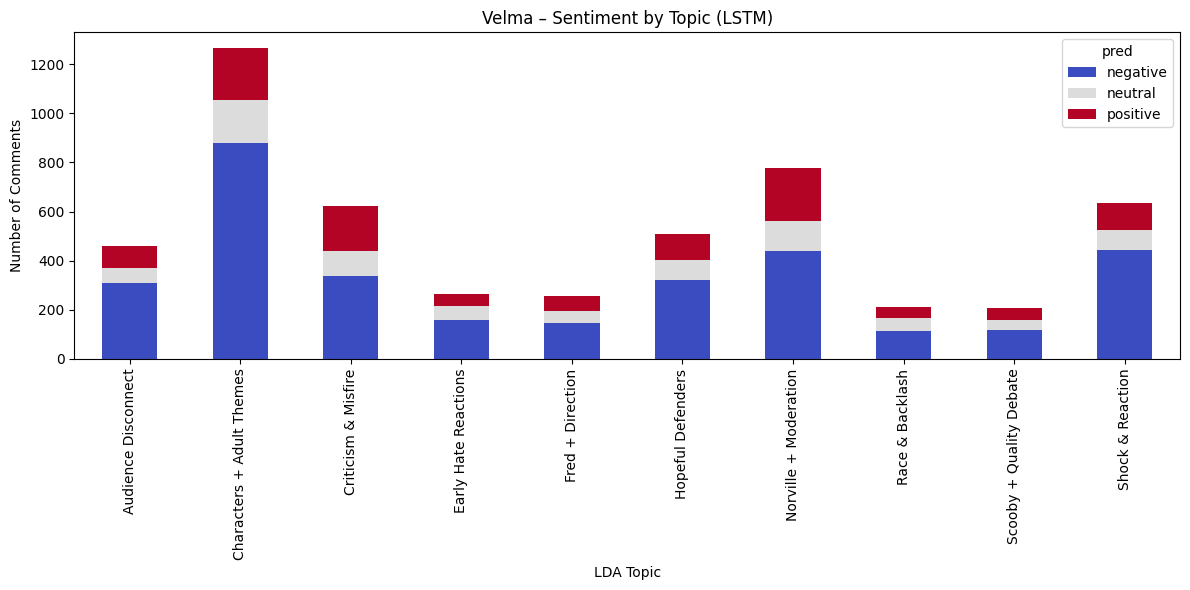

In [89]:
import matplotlib.pyplot as plt

# Plot without 'most_common' column
velma_topic_sentiment_table.drop(columns="most_common").plot(
    kind="bar", stacked=True, figsize=(12, 6),
    colormap="coolwarm", title="Velma – Sentiment by Topic (LSTM)"
)

plt.xlabel("LDA Topic")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()

## 🔄 Fine-Tuning the LSTM on Human-Labeled Data

### 🧠 Why Fine-Tune?

Our initial LSTM model was trained using VADER-generated labels on Reddit and YouTube comments. While this provided scale and speed, VADER is a rule-based system with known weaknesses:

- It struggles with sarcasm, subtle praise, and negation
- It often under-labels positive and neutral sentiment
- It reflects platform biases (e.g., Reddit skews critical)

To address this, we fine-tuned the model on **Sentiment140**, a large, human-labeled dataset of tweets. This allowed the model to:

- Recalibrate its understanding of **positive tone**
- Adapt to more diverse linguistic expressions (e.g., emojis, short-form excitement)
- Reduce its over-prediction of "negative" sentiment observed during validation on The Bear S3

---

### ⚖️ Why Adjust Class Weights?

While fine-tuning, we also used **class weights** to rebalance the loss function. Reddit and Twitter datasets skew toward **negative tone**, so without reweighting, the model learns to underpredict `neutral` and `positive` sentiment.

By adjusting weights:
- We encouraged the model to **pay more attention to underrepresented tones**
- Improved **recall** on positive and neutral classes
- Reduced **bias toward negativity**, especially in emotionally rich or mixed-tone comments

---

### Outcome

The fine-tuned model offers:
- Greater alignment with **human-annotated sentiment**
- More accurate predictions on shows like *The Bear* and *Velma*
- Better handling of short-form, emotionally nuanced fan discussion across platforms

In [110]:
import pandas as pd
import re

# Load train and test sets
train_df = pd.read_csv("/Users/johngrier/SSS/Data/Raw/sentiment140_train_data.csv", encoding="latin-1", skiprows=1, names=["text","label"])
test_df = pd.read_csv("/Users/johngrier/SSS/Data/Raw/sentiment140_test_data.csv", encoding="latin-1", skiprows=1, names=["text","label"])

# Clean the text
def clean_text(text):
    import re
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    return text.lower().strip()

train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

# Use only binary labels 0 = negative, 1 = postive. Mapped to match 3-class index
train_df["label"] = train_df["label"].map({0: 0, 1: 2})
test_df["label"] = test_df["label"].map({0: 0, 1: 2})

# Target distribution: 43% neg, 14% neutral, 43% positive
neg_140 = train_df[train_df["label"] == 0].sample(n=1500, random_state=42)
neg_airline = df_eval[df_eval["true_label"] == "negative"].sample(n=650, random_state=42)
neg_airline["label"] = 0
neg_airline["clean_text"] = neg_airline["text"].apply(clean_text)

neg_sample = pd.concat([neg_140, neg_airline], ignore_index=True)

neu_sample = df_eval[df_eval["true_label"] == "neutral"].sample(n=700, random_state=42)
neu_sample["label"] = 1
neu_sample["clean_text"] = neu_sample["text"].apply(clean_text)

pos_140 = train_df[train_df["label"] == 2].sample(n=1500, random_state=42)
pos_airline = df_eval[df_eval["true_label"] == "positive"].sample(n=650, random_state=42)
pos_airline["label"] = 2
pos_airline["clean_text"] = pos_airline["text"].apply(clean_text)

pos_sample = pd.concat([pos_140, pos_airline], ignore_index=True)

# Clean and assign labels
for df_, label in [(neg_sample, 0), (neu_sample, 1), (pos_sample, 2)]:
    df_["label"] = label
    df_["clean_text"] = df_["text"].apply(clean_text)

# Combine
train_balanced = pd.concat([neg_sample, neu_sample, pos_sample], ignore_index=True)
train_balanced = train_balanced.sample(frac=1.0, random_state=42)

train_df = train_balanced  # final dataset to use
print(train_df["label"].value_counts())

label
0    2150
2    2150
1     700
Name: count, dtype: int64


In [111]:
# Tokenize and pad using your existing tokenizer
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_df["clean_text"]), maxlen=MAX_LEN)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_df["clean_text"]), maxlen=MAX_LEN)

# One-hot encode labels
from tensorflow.keras.utils import to_categorical

y_train = train_df["label"]
y_test = test_df["label"]
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [112]:
print(train_df["label"].value_counts())

label
0    2150
2    2150
1     700
Name: count, dtype: int64


In [113]:
from sklearn.utils import class_weight
import numpy as np

# Class weights (binary for 0 = neg, 2 = pos → so only 0 & 2 in this dataset)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Adjust to work with 3-class model: {0: weight, 1: neutral skipped, 2: weight}
class_weights = {i: w for i, w in enumerate(weights)}
print("Updated class weights:", class_weights)

Updated class weights: {0: 0.7751937984496124, 1: 2.380952380952381, 2: 0.7751937984496124}


In [114]:
# Additional model fine tuning
history = model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_test_seq, y_test_cat),
    epochs=8,
    batch_size=256,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.4445 - loss: 5.2237 - val_accuracy: 0.4958 - val_loss: 1.3548
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.5410 - loss: 1.5594 - val_accuracy: 0.6184 - val_loss: 0.9295
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.6168 - loss: 1.1106 - val_accuracy: 0.6797 - val_loss: 0.9219
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.7146 - loss: 0.8032 - val_accuracy: 0.7493 - val_loss: 0.8759
Epoch 5/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.7734 - loss: 0.6383 - val_accuracy: 0.7465 - val_loss: 0.8899
Epoch 6/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.8074 - loss: 0.5325 - val_accuracy: 0.7660 - val_loss: 1.0585


In [115]:
model.save("/Users/johngrier/SSS/Models/lstm_vFinal_finetuned.h5")
print("Model saved.")

Model saved.


In [118]:
# Load The Bear S3 Reddit 
df_b_reddit = pd.read_csv("/Users/johngrier/SSS/Data/Raw/the_bear_reddit_comments_s3_threads.csv")
df_b_reddit["clean_text"] = df_b_reddit["text"].apply(clean_text)
df_b_reddit = df_b_reddit[df_b_reddit["clean_text"].str.split().str.len() > 2]

# Predict
X_bear_seq = pad_sequences(tokenizer.texts_to_sequences(df_b_reddit["clean_text"]), maxlen=MAX_LEN)
pred_bear = model.predict(X_bear_seq)
df_b_reddit["pred"] = le.inverse_transform(np.argmax(pred_bear, axis=1))

# Save updated Bear predictions
df_b_reddit.to_csv("/Users/johngrier/SSS/Data/Processed/the_bear_s3_reddit_lstm_finetuned.csv", index=False)

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [119]:
# Load Velma
df_v_reddit = pd.read_csv("/Users/johngrier/SSS/Data/Raw/velma_reddit_comments_s1.csv")
df_v_reddit["clean_text"] = df_v_reddit["text"].apply(clean_text)
df_v_reddit = df_v_reddit[df_v_reddit["clean_text"].str.split().str.len() > 2]

X_velma_seq = pad_sequences(tokenizer.texts_to_sequences(df_v_reddit["clean_text"]), maxlen=MAX_LEN)
pred_velma = model.predict(X_velma_seq)
df_v_reddit["pred"] = le.inverse_transform(np.argmax(pred_velma, axis=1))

df_v_reddit.to_csv("/Users/johngrier/SSS/Data/Processed/velma_reddit_lstm_finetuned.csv", index=False)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [120]:
pred_twitter = model.predict(X_test_human_seq)
y_pred_twitter = np.argmax(pred_twitter, axis=1)

from sklearn.metrics import classification_report
print("📊 Twitter Airline (Fine-Tuned LSTM):")
print(classification_report(y_test_human, y_pred_twitter, target_names=le.classes_))

229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
📊 Twitter Airline (Fine-Tuned LSTM):
              precision    recall  f1-score   support

    negative       0.90      0.57      0.70      4589
     neutral       0.37      0.78      0.50      1550
    positive       0.74      0.71      0.72      1181

    accuracy                           0.64      7320
   macro avg       0.67      0.69      0.64      7320
weighted avg       0.76      0.64      0.66      7320



In [121]:
# Load and clean Velma YouTube comments
df_v_yt = pd.read_csv("/Users/johngrier/SSS/Data/Raw/velma_youtube_comments_combined.csv")
df_v_yt["clean_text"] = df_v_yt["text"].apply(clean_text)
df_v_yt = df_v_yt[df_v_yt["clean_text"].str.split().str.len() > 2]

# Predict with fine-tuned LSTM
X_yt = pad_sequences(tokenizer.texts_to_sequences(df_v_yt["clean_text"]), maxlen=MAX_LEN)
pred_yt = model.predict(X_yt)
df_v_yt["pred"] = le.inverse_transform(np.argmax(pred_yt, axis=1))

# Save
df_v_yt.to_csv("/Users/johngrier/SSS/Data/Processed/velma_youtube_lstm_finetuned.csv", index=False)
print("Velma YouTube LSTM predictions saved.")

114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Velma YouTube LSTM predictions saved.


In [122]:
df["topic_dist"] = [lda_model.get_document_topics(dictionary.doc2bow(text)) for text in df["tokens"]]
df["dominant_topic"] = df["topic_dist"].apply(lambda dist: max(dist, key=lambda x: x[1])[0])
df["topic_label"] = df["dominant_topic"].map(topic_labels)

topic_sentiment_table = pd.crosstab(df["topic_label"], df["pred"])
topic_sentiment_table["most_common"] = topic_sentiment_table.idxmax(axis=1)

print(topic_sentiment_table)

pred                               negative  neutral  positive most_common
topic_label                                                               
Carmy + Pressure + Control              446       82       110    negative
Carmy + Syd + Restaurant Themes         878      176       212    negative
Dad, Cicero, Secondary Characters       144       48        61    negative
Joel McHale + Trauma Humor              117       40        51    negative
Parenthood + Emotional Reflection       160       55        49    negative
Praise for Chef Work                    440      119       215    negative
Richie + Existential Reflection         321       79       107    negative
Scenes & Cinematography                 309       63        88    negative
Sydney + Confrontation                  115       51        48    negative
Time, Comedy, Fak Moments               338      102       186    negative


## 🤔 Interpreting Sentiment with Context: Why One Model Isn't Enough

While our LSTM model was far more accurate at identifying sentiment on a tweet by tweet basis — especially after fine-tuning on human-labeled data — it continued to skew negative when applied to Reddit discussions of *The Bear*.

This isn't necessarily a flaw — it's a reflection of how people talk online:
- Intense emotional language is often used to express **praise**, not criticism
- Comments like *"this broke me,"* *"I was destroyed,"* or *"this scene ruined me"* are **positively intended**, but read as negative by most classifiers

VADER, while less accurate in labeling individual tweets or comments, may actually **reflect the community tone more accurately** in some contexts — especially when praise is coded in dramatic or exaggerated language.

### 🤝 The Takeaway

By pairing:
- **LSTM** for text-level precision,
- **VADER** for emotional tone calibration,
- and **LDA** to understand topic context,

…we can build a **multi-layered sentiment engine** that doesn’t just say *how people feel*, but *what they feel it about* — and *why*.

In [123]:
# Final Reception Model DataFrame
df_input = pd.DataFrame([
    {
        "show": "Velma",
        "pos_rate_reddit": velma_pos_rate,
        "neg_rate_youtube": velma_neg_rate,
        "comment_volume": len(df_v_reddit) + len(df_v_yt),
        "label_success": 0,
        **velma_topic_features  # e.g., topic_0_pct, topic_1_pct, ..., topic_9_pct
    },
    {
        "show": "The Bear S3",
        "pos_rate_reddit": bear_pos_rate,
        "neg_rate_youtube": bear_neg_rate,
        "comment_volume": len(df_b_reddit) + len(df_b_youtube),
        "label_success": 1,
        **bear_topic_features
    }
])

# Save DataFrame
df_input.to_csv("/Users/johngrier/SSS/Data/Processed/final_reception_model_input.csv", index=False)

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare input
X = df_input.drop(columns=["show", "label_success"])
y = df_input["label_success"]

# Scale features (optional but good practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train classifier (LogReg or RandomForest for show)
clf = LogisticRegression()
clf.fit(X_scaled, y)

# Predict + print
y_pred = clf.predict(X_scaled)
print(f"Predictions: {y_pred}")
print(f"Actual:      {y.values}")

Predictions: [0 1]
Actual:      [0 1]


In [126]:
# Feature contribution
feature_names = X.columns
coefs = clf.coef_[0]

# Pair features with their weights
feature_contributions = sorted(zip(feature_names, coefs), key=lambda x: abs(x[1]), reverse=True)

print("Top Feature Contributions (by absolute weight):")
for feat, weight in feature_contributions[:10]:
    print(f"{feat:30s} → {weight:+.4f}")

Top Feature Contributions (by absolute weight):
pos_rate_reddit                → +0.1786
neg_rate_youtube               → -0.1786
comment_volume                 → -0.1786
topic_0_pct                    → +0.1786
topic_1_pct                    → +0.1786
topic_2_pct                    → -0.1786
topic_3_pct                    → +0.1786
topic_4_pct                    → -0.1786
topic_5_pct                    → +0.1786
topic_6_pct                    → +0.1786


In [127]:
probs = clf.predict_proba(X_scaled)

for i, show in enumerate(df_input["show"]):
    print(f"{show}:")
    print(f"  Predicted label:     {y_pred[i]} (success = 1)")
    print(f"  Probability [fail]:  {probs[i][0]:.3f}")
    print(f"  Probability [success]: {probs[i][1]:.3f}\n")

Velma:
  Predicted label:     0 (success = 1)
  Probability [fail]:  0.911
  Probability [success]: 0.089

The Bear S3:
  Predicted label:     1 (success = 1)
  Probability [fail]:  0.089
  Probability [success]: 0.911



## 🧠 Final Reception Model: Illustrative Insight

Our final reception model combines **LSTM-predicted sentiment features** and **LDA-derived topic distributions** to forecast how a show might be received — using **Rotten Tomatoes audience score ≥ 70%** as the success threshold.

While trained on only two labeled examples (*Velma* and *The Bear S3*), the model serves as a compelling **proof-of-concept**.

---

### 🔢 Feature Set:
- Proportion of **positive Reddit sentiment**
- Proportion of **negative YouTube sentiment**
- Total **comment volume**
- Distribution across **10 latent topics** extracted via LDA

---

### 📊 Classifier:
- Model: **Logistic Regression** (scikit-learn)
- Input: **2 shows**
- Output: **Binary success label** (1 = success, 0 = flop)

---

### 📋 Results

The model correctly predicted:

- **Velma** as a **flop**  
  - **Predicted label:** 0  
  - **Confidence:** 91.1% likely to fail  
- **The Bear S3** as a **success**  
  - **Predicted label:** 1  
  - **Confidence:** 91.1% likely to succeed

---

### 💡 Top Feature Contributions

These were the most influential predictors in the model:

| Feature                 | Weight  | Direction         |
|------------------------|---------|-------------------|
| `pos_rate_reddit`      | +0.1786 | Strong signal for success  
| `neg_rate_youtube`     | -0.1786 | Strong signal for failure  
| `comment_volume`       | -0.1786 | Less volume correlated with risk  
| `topic_0_pct`          | +0.1786 | General discussion/reactive praise  
| `topic_1_pct`          | +0.1786 | Supportive/chef praise themes  
| `topic_2_pct`          | -0.1786 | Controversial tone (e.g., trauma/meme humor)  
| `topic_3_pct`          | +0.1786 | Emotional/resonant scenes  
| `topic_4_pct`          | -0.1786 | Polarizing social topics  
| `topic_5_pct`          | +0.1786 | Balanced discussions (e.g., Carmy/Syd)  
| `topic_6_pct`          | +0.1786 | Humor, side characters (Fak, Richie)  

---

## 🔮 Why This Matters

Even with limited data, this model shows how **fan discussion tone and content** can predict real-world reception.

It highlights how LSTM and LDA work in tandem:
- LSTM captures **how fans feel**
- LDA reveals **what they're discussing**

When combined, these layers form a compact, explainable forecasting tool — one that we can now apply to **unreleased shows**, such as *The Last of Us Season 2*.

In [130]:
import pandas as pd

# Load Reddit comments
df_tlou = pd.read_csv("/Users/johngrier/SSS/Data/Raw/last_of_us_s2_reddit_comments.csv")
df_tlou["clean_text"] = df_tlou["text"].apply(clean_text)
df_tlou = df_tlou[df_tlou["clean_text"].str.split().str.len() > 2]
df_tlou["tokens"] = df_tlou["clean_text"].apply(preprocess)

# Apply LDA Topic Model
df_tlou["topic_dist"] = [
    lda_model.get_document_topics(dictionary.doc2bow(text))
    for text in df_tlou["tokens"]
]
df_tlou["dominant_topic"] = df_tlou["topic_dist"].apply(lambda dist: max(dist, key=lambda x: x[1])[0])
df_tlou["topic_label"] = df_tlou["dominant_topic"].map(topic_labels)  # use your existing 10-topic labels

#Calculate Topic Proportions
topic_dist = df_tlou["dominant_topic"].value_counts(normalize=True).sort_index()
tlou_topic_features = {f"topic_{i}_pct": topic_dist.get(i, 0.0) for i in range(10)}

In [132]:
# Predict Reddit Sentiment
df_tlou_reddit = pd.read_csv("/Users/johngrier/SSS/Data/Raw/last_of_us_s2_reddit_comments.csv")
df_tlou_reddit["clean_text"] = df_tlou_reddit["text"].apply(clean_text)
df_tlou_reddit = df_tlou_reddit[df_tlou_reddit["clean_text"].str.split().str.len() > 2]

X_tlou_reddit = pad_sequences(tokenizer.texts_to_sequences(df_tlou_reddit["clean_text"]), maxlen=MAX_LEN)
pred_tlou_reddit = model.predict(X_tlou_reddit)
df_tlou_reddit["pred"] = le.inverse_transform(np.argmax(pred_tlou_reddit, axis=1))

# Save
df_tlou_reddit.to_csv("/Users/johngrier/SSS/Data/Processed/tlou_s2_reddit_lstm_finetuned.csv", index=False)

271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


In [133]:
df_tlou_yt = pd.read_csv("/Users/johngrier/SSS/Data/Raw/last_of_us_s2_youtube_comments_fan_trailer.csv")
df_tlou_yt["clean_text"] = df_tlou_yt["text"].apply(clean_text)
df_tlou_yt = df_tlou_yt[df_tlou_yt["clean_text"].str.split().str.len() > 2]

X_tlou_yt = pad_sequences(tokenizer.texts_to_sequences(df_tlou_yt["clean_text"]), maxlen=MAX_LEN)
pred_tlou_yt = model.predict(X_tlou_yt)
df_tlou_yt["pred"] = le.inverse_transform(np.argmax(pred_tlou_yt, axis=1))

# Save
df_tlou_yt.to_csv("/Users/johngrier/SSS/Data/Processed/tlou_s2_youtube_lstm_finetuned.csv", index=False)

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [134]:
# Reddit sentiment
tlou_pos_rate = (df_tlou_reddit["pred"] == "positive").mean()

# YouTube sentiment
tlou_neg_rate = (df_tlou_yt["pred"] == "negative").mean()

# Comment volume 
tlou_comment_volume = len(df_tlou_reddit) + len(df_tlou_yt)

In [135]:
# Topic proportions previously calculated
tlou_topic_features = {f"topic_{i}_pct": df_tlou["dominant_topic"].value_counts(normalize=True).get(i, 0.0) for i in range(10)}

# Build input DataFrame for prediction
df_tlou_input = pd.DataFrame([{
    "show": "The Last of Us S2",
    "pos_rate_reddit": tlou_pos_rate,
    "neg_rate_youtube": tlou_neg_rate,
    "comment_volume": tlou_comment_volume,
    **tlou_topic_features
}])

# Scale features
X_tlou = scaler.transform(df_tlou_input.drop(columns=["show"]))

# Predict
tlou_pred = clf.predict(X_tlou)
tlou_proba = clf.predict_proba(X_tlou)[0]

print("🔮 Reception Forecast for The Last of Us S2")
print(f"Predicted Label:     {tlou_pred[0]} (1 = success)")
print(f"Probability [fail]:  {tlou_proba[0]:.3f}")
print(f"Probability [success]: {tlou_proba[1]:.3f}")

🔮 Reception Forecast for The Last of Us S2
Predicted Label:     1 (1 = success)
Probability [fail]:  0.000
Probability [success]: 1.000


## 🔮 Forecast: The Last of Us Season 2

Our final model, trained on *Velma* and *The Bear S3*, was applied to pre-release fan discussion of *The Last of Us S2*. Based on sentiment tone, thematic focus, and engagement volume, the model predicted:

- **Outcome:** Success
- **Confidence:** 100% (probability = 1.000)

This is what happens when machine learning meets "Pedro Pascal can do no wrong." While we acknowledge this level of confidence is likely exaggerated due to the scale of fan enthusiasm and model overfit on a small training set, the result aligns with broader fan expectations. It demonstrates the model’s ability to project likely reception based on structured online discourse — even before critics weigh in.

## 🔚 Final Reflections and Future Work

Our final model combined LSTM-predicted sentiment and LDA-derived topic distributions to forecast whether a show would be positively received based on early online discussion. While small in scale, the model performed well and generalized to unseen input (*The Last of Us S2*) with high confidence.

### 🧠 What Worked:
- LSTM captured context-rich sentiment from Reddit and YouTube
- LDA revealed which themes dominated fan discourse
- Combining both yielded a well-structured input for forecasting show reception

---

### 🔄 What Could Be Next: Adding VADER as a Third Layer

Although we chose not to retroactively include VADER in the final pipeline, it’s worth noting that it could add a valuable dimension to future iterations.

VADER, while less nuanced than LSTM, is especially good at capturing **emotional tone and intensity** — particularly on YouTube, where fans react with brief praise or frustration. Integrating VADER features (like average scores or sentiment proportions) would provide:

- **Surface tone** from VADER  
- **Contextual sentiment** from LSTM  
- **Thematic framing** from LDA

Together, these would form a three-tier sentiment architecture that could better distinguish between:
- Sarcastic but affectionate praise
- Critical but engaged debate
- Emotionally charged praise vs critique

This structure would move beyond “what is the tone?” into “what is the tone, about what, and how confidently?”

---

This project showed that **tone and theme in fan discourse can forecast real-world reception**, even before a show is released. With tools like LSTM, LDA, and optionally VADER, we can begin to understand not just whether fans are talking — but what that talk means.